<a href="https://colab.research.google.com/github/soobook/PyTorch-DL/blob/main/code/PT14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 14회차: RNN을 활용한 영화평 감성 분석 (4) - 모델 최적화

## 고급 RNN 구현: LSTM 또는 GRU 구조 선택 IMDB 영화평 감성 분석



In [1]:
# 1. 라이브러리
import torch, numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from sklearn.utils import class_weight
import matplotlib.pyplot as plt

# 2-1. GPU 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


In [2]:
# 2-2. 주요 하이퍼패라미터 설정
vocab_size = 10000 # 사용할 단어 집합 크기 (IMDB 상위 10,000개 단어만 사용)
max_len = 500      # 입력 시퀀스 최대 길이 (부족하면 패딩, 초과하면 잘림)
batch_size = 64    # 한 번에 학습할 샘플 수 (메모리 효율과 학습 안정성에 영향)
embed_dim = 128    # 각 단어를 벡터로 변환할 때의 임베딩 차원 수
hidden_dim = 128   # RNN의 은닉 상태(hidden state) 차원 수, 문맥 요약 크기
epochs = 30        # 전체 학습 반복 횟수 (데이터셋 전체를 30번 반복 학습)
use_gru = True     # True면 GRU 사용, False면 LSTM 사용 (성능/속도 트레이드오프 있음)
num_layers = 1     # RNN 계층 수 (1이면 얕은 구조, 2 이상이면 deep RNN)

In [3]:
# 3. 데이터 로딩 및 전처리
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=vocab_size)
x_train = pad_sequences(x_train, maxlen=max_len)
x_test = pad_sequences(x_test, maxlen=max_len)
x_train_tensor = torch.tensor(x_train, dtype=torch.long)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [4]:
# 4. 불균형 처리: class_weight → weight tensor
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
weight_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
print(weight_tensor)

tensor([1., 1.], device='cuda:0')


In [ ]:
# 불균형 처리 샘플 코드
# class 0: 3개, class 1: 2개
y_train_test = [0, 0, 0, 1, 1]
class_weights_test = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train_test), y=y_train_test)
print(class_weights_test) #  ≈ [0.83, 1.25]
weight_tensor_test = torch.tensor(class_weights_test, dtype=torch.float32).to(device)
print(weight_tensor_test)

[0.83333333 1.25      ]
tensor([0.8333, 1.2500], device='cuda:0')


In [5]:
# 5. DataLoader
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [6]:
# 6. 모델 정의
class RecurrentClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, use_gru=False, dropout=0.3, num_layers=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.use_gru = use_gru
        self.num_layers = num_layers
        rnn_dropout = dropout if num_layers > 1 else 0.0
        self.rnn = nn.GRU(embed_dim, hidden_dim, batch_first=True, dropout=rnn_dropout, num_layers=num_layers) if use_gru \
                   else nn.LSTM(embed_dim, hidden_dim, batch_first=True, dropout=rnn_dropout, num_layers=num_layers)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        _, h = self.rnn(x)
        hidden = h[-1] if self.use_gru else h[0][-1]
        hidden = self.dropout(hidden)
        return self.sigmoid(self.fc(hidden)).squeeze()

In [7]:
# 7. 모델/손실/옵티마이저
model = RecurrentClassifier(vocab_size, embed_dim, hidden_dim, use_gru=use_gru,
                            dropout=0.3, num_layers=num_layers).to(device)
criterion = nn.BCELoss()  # 클래스 가중치는 아래에서 직접 적용
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

In [ ]:
# weights를 사용해 정답 레이블 수정 계산 샘플 코드
weight_tensor_test = torch.tensor([0.8, 1.2])     # 클래스별 가중치: 0 → 0.8, 1 → 1.2
labels_test = torch.tensor([0, 1, 0, 1])          # 배치 내 레이블들
weights_test = weight_tensor_test[labels_test]    # 결과: [0.8, 1.2, 0.8, 1.2]
weights_test

tensor([0.8000, 1.2000, 0.8000, 1.2000])

In [8]:
# 8. 학습 루프
train_losses = []
print("Training started...")
for epoch in range(epochs):
    model.train()
    running_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        # 각 샘플별 클래스에 해당하는 weight 선택
        weights = weight_tensor[labels.long()]
        loss = criterion(outputs, labels)
        # 최종 손실 = 평균(샘플별 손실 × 샘플별 클래스 가중치)
        loss = (loss * weights).mean() # 클래스별 가중치 반영한 손실
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    scheduler.step()
    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.8f}")

Training started...
Epoch 1/30, Loss: 0.5761, LR: 0.00100000
Epoch 2/30, Loss: 0.3896, LR: 0.00050000
Epoch 3/30, Loss: 0.2594, LR: 0.00050000
Epoch 4/30, Loss: 0.2141, LR: 0.00025000
Epoch 5/30, Loss: 0.1709, LR: 0.00025000
Epoch 6/30, Loss: 0.1520, LR: 0.00012500
Epoch 7/30, Loss: 0.1307, LR: 0.00012500
Epoch 8/30, Loss: 0.1187, LR: 0.00006250
Epoch 9/30, Loss: 0.1071, LR: 0.00006250
Epoch 10/30, Loss: 0.1019, LR: 0.00003125
Epoch 11/30, Loss: 0.0953, LR: 0.00003125
Epoch 12/30, Loss: 0.0932, LR: 0.00001563
Epoch 13/30, Loss: 0.0905, LR: 0.00001563
Epoch 14/30, Loss: 0.0887, LR: 0.00000781
Epoch 15/30, Loss: 0.0869, LR: 0.00000781
Epoch 16/30, Loss: 0.0862, LR: 0.00000391
Epoch 17/30, Loss: 0.0853, LR: 0.00000391
Epoch 18/30, Loss: 0.0858, LR: 0.00000195
Epoch 19/30, Loss: 0.0847, LR: 0.00000195
Epoch 20/30, Loss: 0.0844, LR: 0.00000098
Epoch 21/30, Loss: 0.0846, LR: 0.00000098
Epoch 22/30, Loss: 0.0845, LR: 0.00000049
Epoch 23/30, Loss: 0.0842, LR: 0.00000049
Epoch 24/30, Loss: 0.08

In [9]:
# 9. 평가 함수
def evaluate(model, dataloader):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

# 10. 평가 결과
acc = evaluate(model, test_loader)
print(f"Test Accuracy: {acc * 100:.2f}%")

Test Accuracy: 89.26%


In [10]:
%config InlineBackend.figure_format = 'retina'

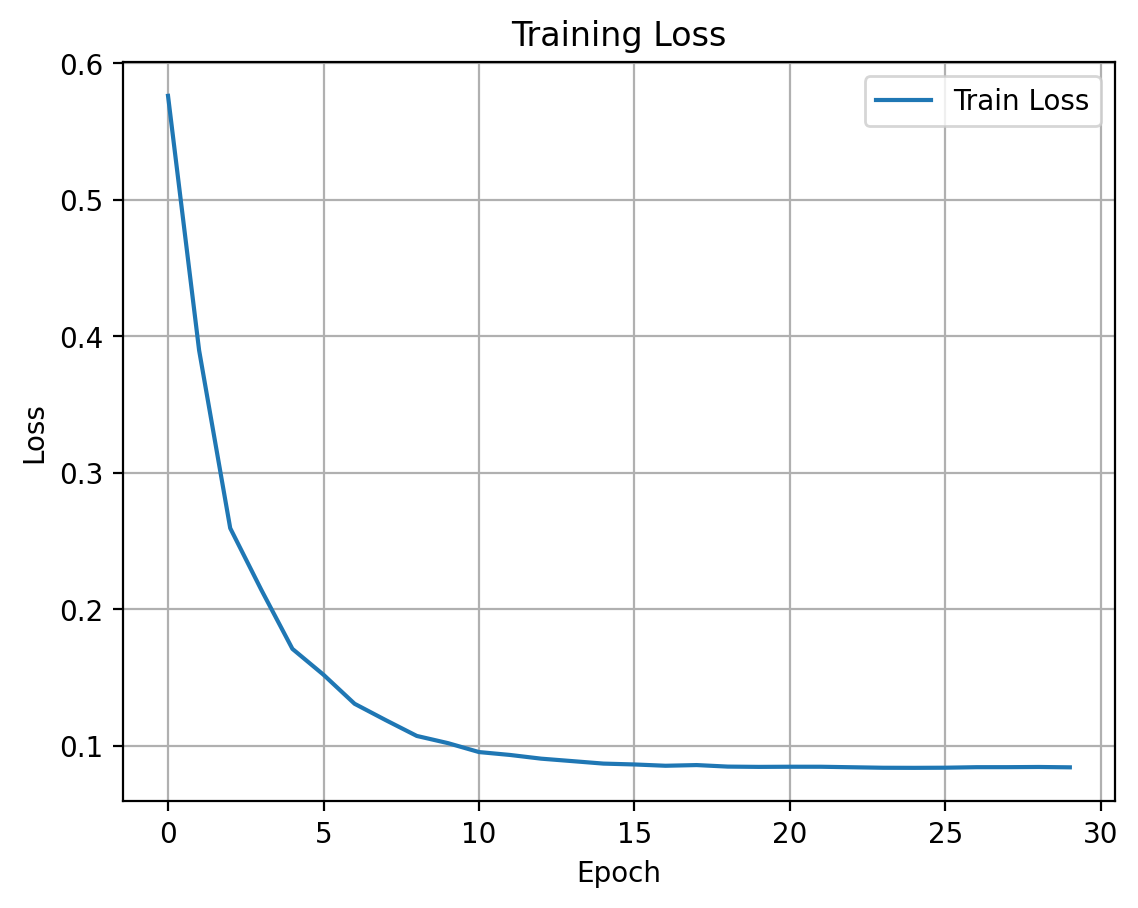

In [11]:
# 11. 손실 시각화
plt.plot(train_losses, label='Train Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.grid()
plt.show()

## 종료